<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/lfc_disturbance_prediction_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Loading & Plotting

Load and plot the training data

               0       0.1   0.2
0       0.100000  0.000000  0.00
1       0.200000  0.000000  0.00
2       0.300000  0.000000  0.00
3       0.400000  0.000000  0.00
4       0.500000  0.000000  0.00
...          ...       ...   ...
5012  499.600006 -0.000005  0.07
5013  499.700012 -0.000005  0.07
5014  499.799988 -0.000004  0.07
5015  499.899994 -0.000004  0.07
5016  500.000000 -0.000004  0.07

[5017 rows x 3 columns]
               0       0.1   0.2
0       0.100000  0.000000  0.00
20      2.100000  0.000000  0.00
40      4.100000  0.000000  0.00
60      5.900000  0.000000  0.00
80      7.900000  0.000000  0.00
...          ...       ...   ...
4920  490.399994 -0.000007  0.07
4940  492.399994 -0.000006  0.07
4960  494.399994 -0.000006  0.07
4980  496.399994 -0.000005  0.07
5000  498.399994 -0.000005  0.07

[251 rows x 3 columns]


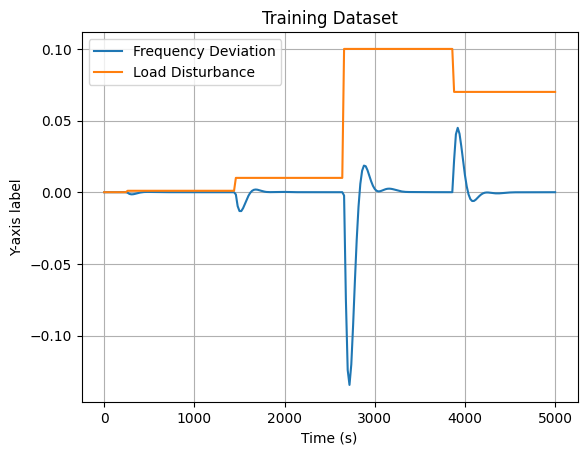

In [116]:
train_dataset_df = pd.read_csv('train_dataset.csv', dtype=np.float32)
print(train_dataset_df)
train_dataset_df = train_dataset_df[train_dataset_df.index % 20 == 0]
print(train_dataset_df)

plt.figure()
plt.plot(train_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(train_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

Load and plot the testing data

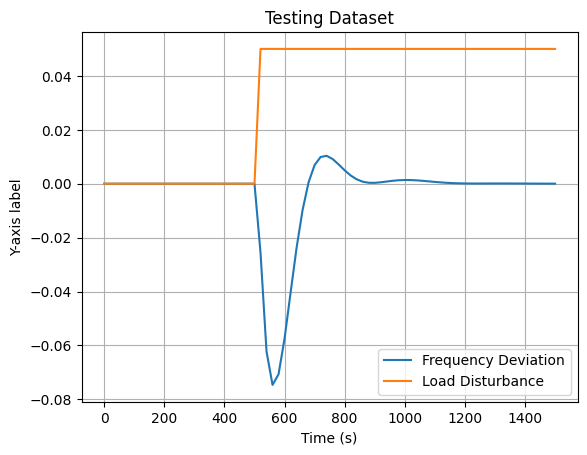

In [117]:
test_dataset_df = pd.read_csv('test_dataset.csv', dtype=np.float32)
test_dataset_df = test_dataset_df[test_dataset_df.index % 20 == 0]

plt.figure()
plt.plot(test_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(test_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Testing Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Data preprocess

**Pipeline description**:

csv format →  data frame → numpy → tensor

In [89]:
def windowed_array(arr, window_size):
    # Calculate the number of subarrays
    num_windows = len(arr) - window_size + 1

    # Create an empty array to store the result
    result = np.empty((num_windows, window_size), dtype=arr.dtype)

    # Fill the result array with windowed slices
    for i in range(num_windows):
        result[i] = arr[i:i+window_size]

    return result

class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = torch.tensor(inputs)
        self.inputs = torch.unsqueeze(self.inputs, dim=2)

        self.outputs = torch.tensor(outputs)
        self.outputs = torch.unsqueeze(self.outputs, dim=2)

    def __len__(self):
        return len(self.inputs)  # Assuming all arrays have the same length

    def __getitem__(self, index):
        sample = tuple((self.inputs[index], self.outputs[index]))
        return sample

In [118]:
# for now, keep historical_window equal to prediction_window
# if not equal, the consider padding method
historical_window = 10
prediction_window = 10

# training data preprocess

X_train = train_dataset_df.iloc[:, 1].to_numpy()
y_train = train_dataset_df.iloc[:, 2].to_numpy()

X_train = X_train[:len(X_train)-historical_window]
y_train = y_train[prediction_window:]

X_train = windowed_array(X_train, historical_window)
y_train = windowed_array(y_train, prediction_window)

train_tensor = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

# testing data preprocess

X_test = test_dataset_df.iloc[:, 1].to_numpy()
y_test = test_dataset_df.iloc[:, 2].to_numpy()

X_test = X_test[:len(X_test)-historical_window]
y_test = y_test[prediction_window:]

X_test = windowed_array(X_test, historical_window)
y_test = windowed_array(y_test, prediction_window)

test_tensor = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=True)

# RNN Definition & Initilization

Define the architecture of the RNN using a class

In [111]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(CustomRNN, self).__init__()
        self.hidden_dim = hidden_dim

        self.rnn = nn.RNN(input_size, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        out, hidden = self.rnn(x)

        out = self.linear(out)
        return out, hidden

In [119]:
# define feedforward neural network architecture
input_size = 1
hidden_size = 8
output_size = 1

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = CustomRNN(input_size, hidden_size, output_size)
net = nn.DataParallel(net)
net = net.to(device)

# define loss function and optimizer
criterion = nn.MSELoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.SGD(net.parameters(), lr=0.1)

# RNN Training

In [123]:
epochs = 1000
training_loss = []

# initialize the hidden state
hidden = None

for e in range(epochs):

    total_batch_loss = 0.0
    average_batch_loss = 0.0

    # forward pass
    for i_batch, (timeseries_batch, label_batch) in enumerate(train_loader):

        timeseries_batch = timeseries_batch.to(device)
        label_batch = label_batch.to(device)

        # nullify gradients for every batch
        optimizer.zero_grad()

        prediction, hidden = net(timeseries_batch, hidden)

        hidden = hidden.data

        # compute loss and store the total loss in each epoch
        loss = criterion(prediction, label_batch)
        total_batch_loss += loss.item()

        # backpropagation
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

    average_batch_loss = total_batch_loss / len(train_loader)
    training_loss.append(average_batch_loss)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(e+1, epochs, average_batch_loss))

Epoch [1/1000], Loss: 0.0018
Epoch [2/1000], Loss: 0.0018
Epoch [3/1000], Loss: 0.0018
Epoch [4/1000], Loss: 0.0018
Epoch [5/1000], Loss: 0.0018
Epoch [6/1000], Loss: 0.0018
Epoch [7/1000], Loss: 0.0018
Epoch [8/1000], Loss: 0.0018
Epoch [9/1000], Loss: 0.0018
Epoch [10/1000], Loss: 0.0018
Epoch [11/1000], Loss: 0.0018
Epoch [12/1000], Loss: 0.0018
Epoch [13/1000], Loss: 0.0018
Epoch [14/1000], Loss: 0.0018
Epoch [15/1000], Loss: 0.0018
Epoch [16/1000], Loss: 0.0018
Epoch [17/1000], Loss: 0.0018
Epoch [18/1000], Loss: 0.0018
Epoch [19/1000], Loss: 0.0018
Epoch [20/1000], Loss: 0.0018
Epoch [21/1000], Loss: 0.0018
Epoch [22/1000], Loss: 0.0018
Epoch [23/1000], Loss: 0.0018
Epoch [24/1000], Loss: 0.0018
Epoch [25/1000], Loss: 0.0018
Epoch [26/1000], Loss: 0.0018
Epoch [27/1000], Loss: 0.0018
Epoch [28/1000], Loss: 0.0018
Epoch [29/1000], Loss: 0.0018
Epoch [30/1000], Loss: 0.0018
Epoch [31/1000], Loss: 0.0018
Epoch [32/1000], Loss: 0.0018
Epoch [33/1000], Loss: 0.0018
Epoch [34/1000], Lo

Plot training loss

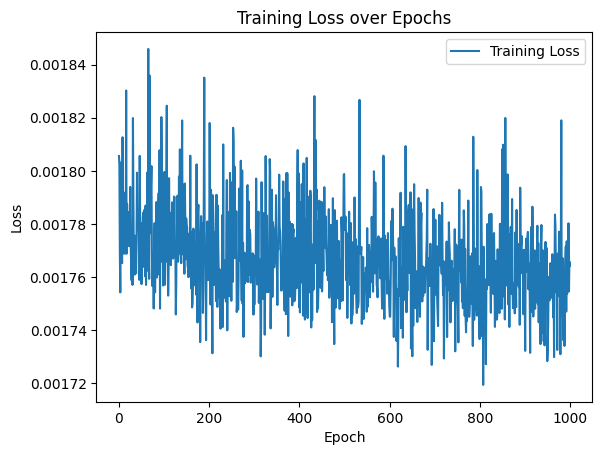

In [124]:
# Plot the training loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Model evaluation

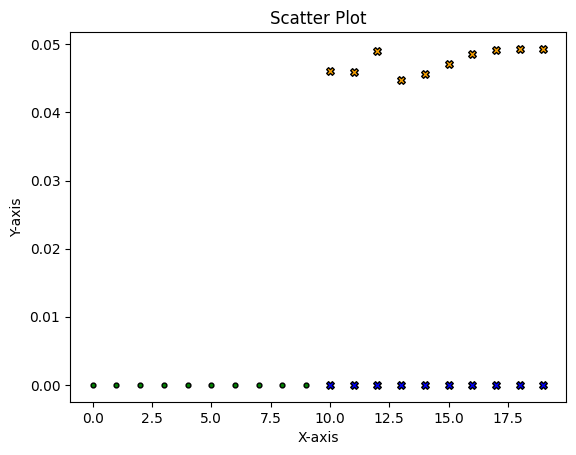

In [125]:
for i, (test_input, test_target) in enumerate(test_tensor):
    if i ==0:
        predicted, _ = net(test_input, None)

        test_input = test_input.numpy()
        test_target = test_target.numpy()
        predicted = predicted.detach().numpy()

        t_max = len(test_target) + len(test_target)
        t = np.arange(0, t_max)

        # Plot dots
        plt.scatter(t[:len(test_input)], test_input, color='green', edgecolors='black', s=12)
        plt.scatter(t[len(predicted):], predicted, color='orange', marker='X', edgecolors='black', s=30)
        plt.scatter(t[len(test_target):], test_target, color='blue', marker='X', edgecolors='black', s=30)

        # Set labels and title
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('Scatter Plot')

        # Show plot
        plt.show()

In [ ]:
num_points = 150
seq_length = 10

t = np.linspace(0, 10*np.pi, num_points)
sine_values = np.sin(t)
cosine_values = np.cos(t)



# Convert to PyTorch tensors
sine_tensor = torch.tensor(sine_values, dtype=torch.float32)
cosine_tensor = torch.tensor(cosine_values, dtype=torch.float32)

# Create sequences of sine values as input and corresponding cosine values as output
input_data = torch.stack([sine_tensor[i:i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(2)
output_data = torch.stack([cosine_tensor[i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(1)

print(input_data[0], output_data[0])

tensor([[0.0000],
        [0.2093],
        [0.4093],
        [0.5912],
        [0.7469],
        [0.8695],
        [0.9536],
        [0.9955],
        [0.9933],
        [0.9471]]) tensor([-0.5121])
